In [2]:
import pandas as pd
import folium
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,10)

## Общие представления о данных

In [58]:
data = pd.read_csv('data.csv', sep='\t', index_col=0)

In [187]:
data.columns

Index([u'amenity_hospital', u'shop_convenience', u'shop_convenience_3',
       u'amenity_nightclub', u'amenity_fast_food', u'amenity_fast_food_3',
       u'man_made_works', u'amenity_public_bath', u'amenity_doctors',
       u'leisure_sports_centre', u'amenity_theatre', u'leisure_fitness_centre',
       u'amenity_cafe', u'amenity_cafe_3', u'amenity_clinic',
       u'highway_bus_stop', u'highway_bus_stop_3', u'amenity_food_court',
       u'leisure_swimming_pool', u'amenity_pub', u'amenity_kindergarten',
       u'leisure_pitch', u'leisure_park', u'leisure_ice_rink',
       u'amenity_marketplace', u'railway_subway_entrance',
       u'railway_subway_entrance_3', u'leisure_dance', u'amenity_university',
       u'amenity_place_of_worship', u'leisure_stadium', u'shop_mall',
       u'shop_general', u'amenity_school', u'amenity_school_3',
       u'leisure_beach_resort', u'amenity_cinema', u'shop_department_store',
       u'amenity_bank', u'amenity_bank_3', u'leisure_playground',
       u'leisure

In [4]:
data.head()

,amenity_hospital,shop_convenience,shop_convenience_3,amenity_nightclub,amenity_fast_food,amenity_fast_food_3,man_made_works,amenity_doctors,leisure_sports_centre,amenity_theatre,...,leisure_playground_3,amenity_dentist,railway_tram_stop,amenity_restaurant,amenity_restaurant_3,shop_supermarket,shop_supermarket_3,amenity_arts_centre,build_year,dist_to_center
0,2512.1,342.1,453.133333,8382.6,2275.9,2293.7,9954.3,346.2,1464.6,6056.6,...,267.333333,386.3,9880.4,1625.5,1667.2,349.6,528.200000,1501.7,1988,16244.8
1,2573.7,280.5,432.600000,8444.2,2337.5,2355.3,9892.7,284.6,1526.2,6118.2,...,249.733333,324.7,9942.0,1616.3,1705.2,288.0,466.600000,1563.3,1988,16306.4
2,2678.4,232.4,435.433333,8548.9,2442.2,2460.0,9788.0,236.5,1493.7,6222.9,...,171.066667,276.6,10046.7,1511.6,1740.1,239.9,380.766667,1668.0,1988,16411.1
3,2775.3,413.9,630.833333,8904.2,2797.5,2815.3,9866.7,317.8,1381.6,6578.2,...,98.400000,369.7,10402.0,1758.0,2059.1,406.4,585.800000,2023.3,1988,16766.4
4,2964.5,431.9,688.433333,8867.1,2760.4,2778.2,10055.7,280.7,1298.9,6541.1,...,148.300000,445.9,10364.9,1870.0,2071.7,439.4,675.633333,1986.2,1988,16729.3


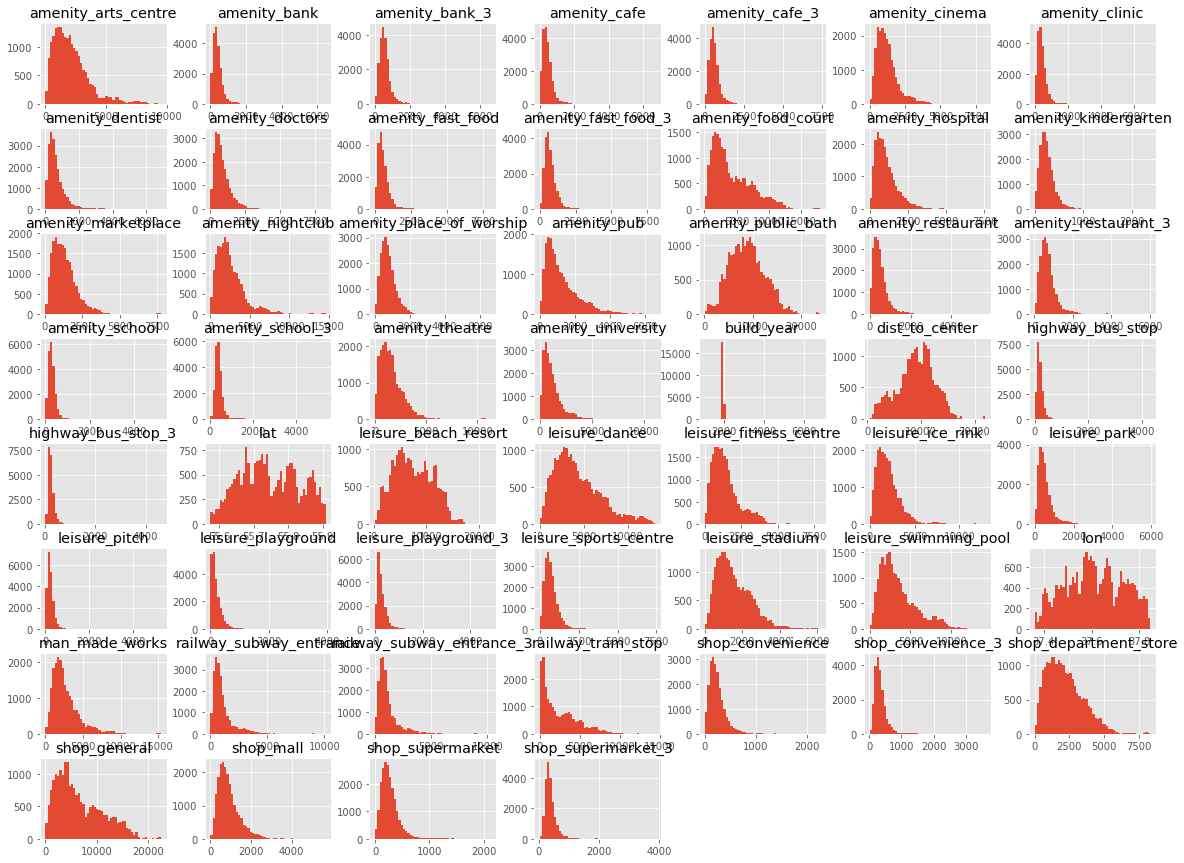

In [200]:
data.hist(bins=50, figsize=(20,15))
plt.show()

## Обработка данных

In [59]:
del data['amenity_public_bath']

In [232]:
corr_matrix = data.corr()

In [233]:
correlations = []
cols = []
for column in data.columns:
    res = corr_matrix[column].sort_values(ascending=False)[:2]
    correlations.extend([round(res[1],2)])
    cols.extend([res.index[1]])

c = pd.DataFrame({'correlation':correlations, 'column':cols}, index=data.columns)
big_c = c[c.correlation>0.69][:]
print c[c.correlation>0.69]

                                              column  correlation
shop_convenience                  shop_convenience_3         0.78
shop_convenience_3                  shop_convenience         0.78
amenity_fast_food                amenity_fast_food_3         0.96
amenity_fast_food_3                amenity_fast_food         0.96
amenity_cafe                          amenity_cafe_3         0.94
amenity_cafe_3                          amenity_cafe         0.94
highway_bus_stop                  highway_bus_stop_3         0.93
highway_bus_stop_3                  highway_bus_stop         0.93
amenity_food_court                      shop_general         0.82
railway_subway_entrance    railway_subway_entrance_3         0.99
railway_subway_entrance_3    railway_subway_entrance         0.99
shop_general                      amenity_food_court         0.82
amenity_school                      amenity_school_3         0.73
amenity_school_3                      amenity_school         0.73
amenity_ba

In [5]:
del data['amenity_fast_food']
del data['amenity_cafe']
del data['highway_bus_stop']
del data['amenity_food_court']
del data['railway_subway_entrance_3']
del data['leisure_playground_3']
del data['amenity_restaurant_3']
del data['shop_convenience']
del data['amenity_school_3']
del data['amenity_bank_3']
del data['shop_supermarket_3']

## Почему удаляем именно эти столбцы из коррелирующих?

Фаст-фуд, кафе, автобусные остановки, магазины шаговой доступности - человека интересует несколько ближайших объектов.

Метро, ресторан, спортплощадки, школы, банки, супермаркеты - ситуация обратная. 

Фуд-корт, общественные бани - наименее важные признаки.

In [235]:
data.shape

(20998, 41)

In [6]:
df = data[:].iloc[np.random.permutation(data.shape[0])]

In [7]:
lat = df['lat']
lon = df['lon']

In [8]:
del df['lat']
del df['lon']
X = df[:2000].values
X.shape

(2000, 39)

In [304]:
df.columns

Index([u'amenity_hospital', u'shop_convenience_3', u'amenity_nightclub',
       u'amenity_fast_food_3', u'man_made_works', u'amenity_public_bath',
       u'amenity_doctors', u'leisure_sports_centre', u'amenity_theatre',
       u'leisure_fitness_centre', u'amenity_cafe_3', u'amenity_clinic',
       u'highway_bus_stop_3', u'leisure_swimming_pool', u'amenity_pub',
       u'amenity_kindergarten', u'leisure_pitch', u'leisure_park',
       u'leisure_ice_rink', u'amenity_marketplace', u'railway_subway_entrance',
       u'leisure_dance', u'amenity_university', u'amenity_place_of_worship',
       u'leisure_stadium', u'shop_mall', u'shop_general', u'amenity_school',
       u'leisure_beach_resort', u'amenity_cinema', u'shop_department_store',
       u'amenity_bank', u'leisure_playground', u'amenity_dentist',
       u'railway_tram_stop', u'amenity_restaurant', u'shop_supermarket',
       u'amenity_arts_centre', u'build_year', u'dist_to_center'],
      dtype='object')

In [9]:
X_mean = X.mean(0)
X_norm = X.std(0)
X = (X - X.mean(0)) / X.std(0)

## Используемые алгоритмы

1) KMeans, а именно модификация kmeans++;

2) DBSCAN;

3) Иерархический аггломеративный алгоритм, типы связи - complete, average, ward;

4) Если кто-то захочет - EM.

## Применение KMeans

Критерии:

1) Инерция;

2) Средний радиус;

3) Средний диаметр(основная метрика).

Средний диаметр выбран потому, что мы хотим выбрать наиболее компактные классы по выбранным признакам. 

### Инерция

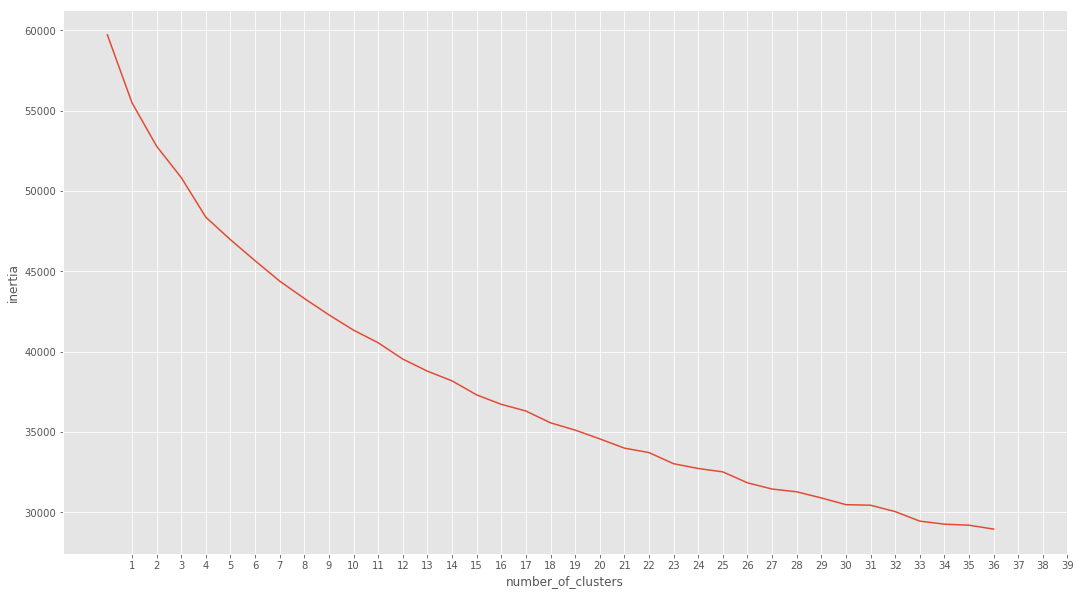

In [52]:
inertia = []
for i in xrange(3, 40):
    model = KMeans(n_clusters=i, max_iter=300)
    y = model.fit_predict(X)
    inertia.append(model.inertia_)
plt.plot(inertia)
plt.xticks(np.arange(1, 40, 1))
plt.xlabel("number_of_clusters")
plt.ylabel("inertia")

### Средний радиус

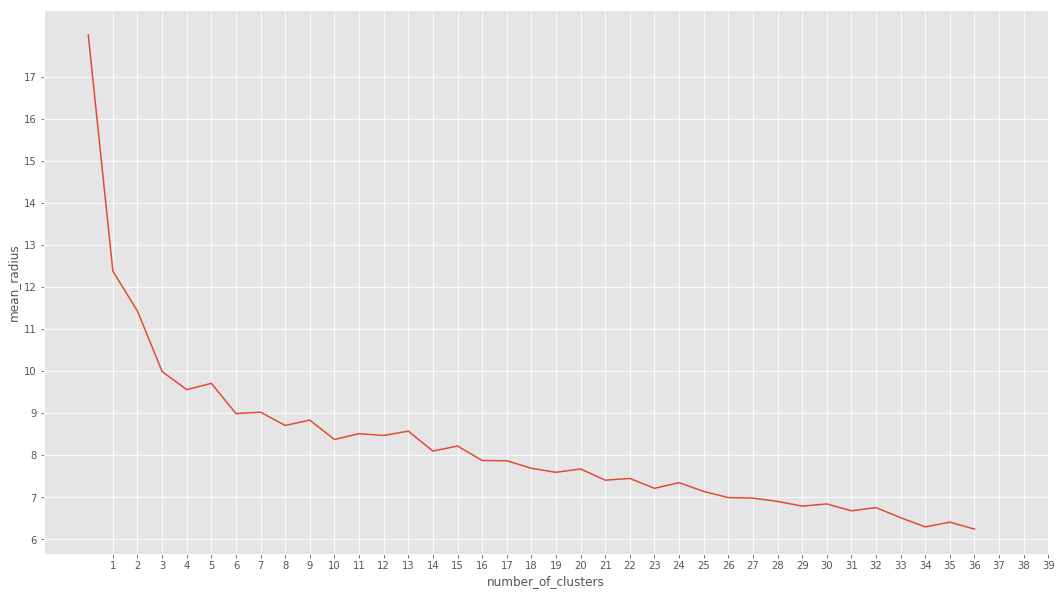

In [53]:
rads = []
for i in xrange(3, 40):
    model = KMeans(n_clusters=i, max_iter=300)
    y = model.fit_predict(X)
    Y = model.transform(X)
    sum = 0
    for label in xrange(i):
        sum += Y[np.where(model.labels_==label)].max(0)[label]
    rads.append(sum/float(i))
plt.plot(rads)
plt.xticks(np.arange(1, 40))
plt.yticks(np.arange(6, 18))
plt.xlabel("number_of_clusters")
plt.ylabel("mean_radius")

### Средний диаметр

In [11]:
from scipy.spatial.distance import pdist

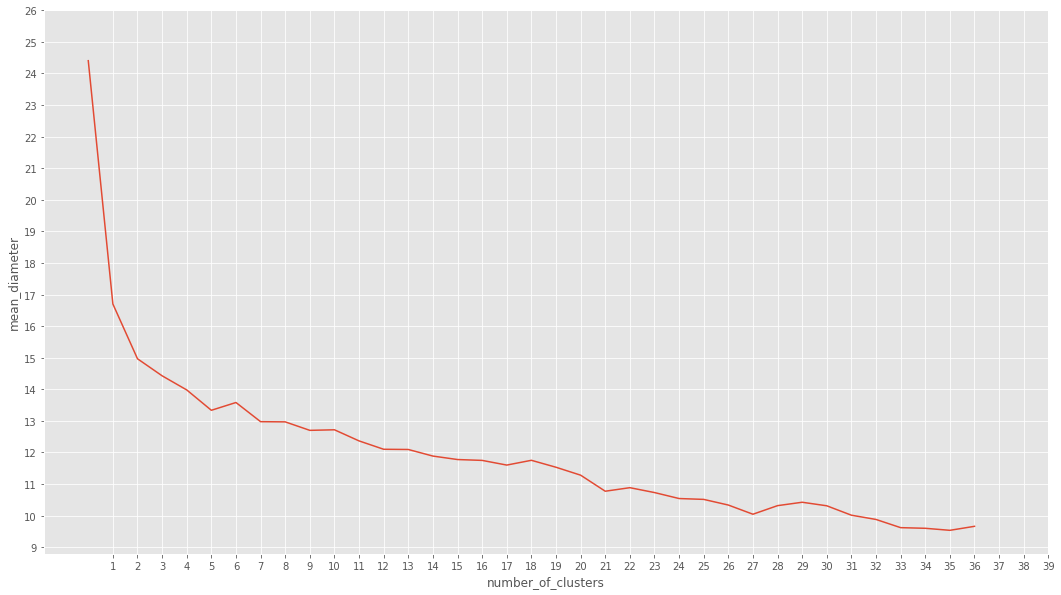

In [60]:
diams = []
for i in xrange(3, 40):
    model = KMeans(n_clusters=i, max_iter=300)
    y = model.fit_predict(X)
    sum = 0
    clusts_not_null = 0
    for label in xrange(i):
        dists = pdist(X[np.where(model.labels_==label)])
        if len(dists) != 0: 
            sum += dists.max()
            clusts_not_null += 1
    diams.append(sum/float(clusts_not_null))
plt.plot(diams)
plt.xticks(np.arange(1, 40))
plt.yticks(np.arange(9, 27))
plt.xlabel("number_of_clusters")
plt.ylabel("mean_diameter")

## Применение DBSCAN

В презентацию лучше не включать.

In [22]:
from collections import Counter

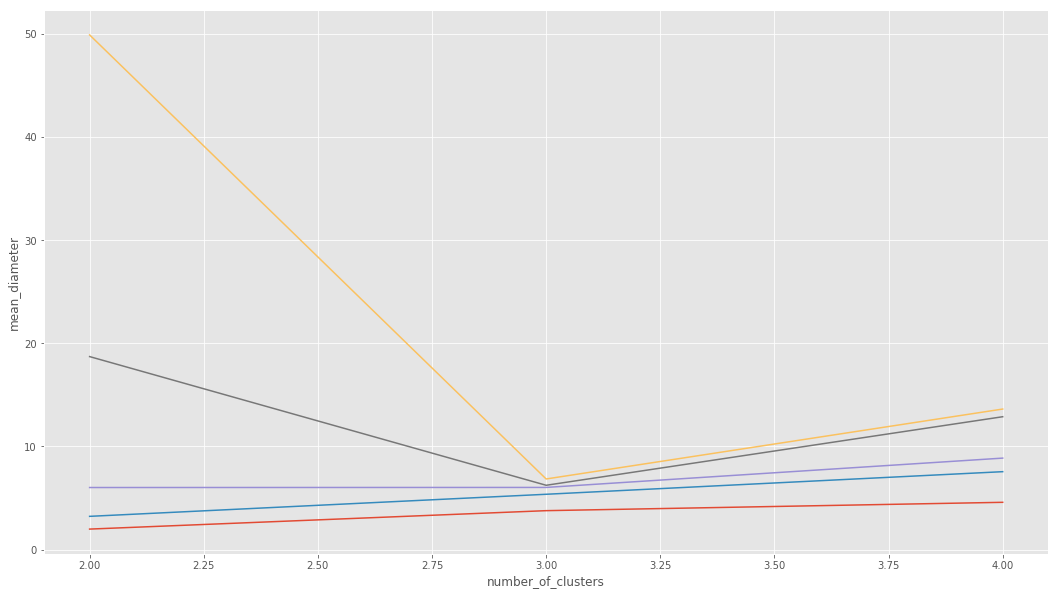

In [24]:
for i in xrange(2, 12, 2):
    diams = []
    for eps in np.linspace(2., 4., 3):
        model = DBSCAN(eps=eps, min_samples=i)
        model.fit(X)
        y = model.labels_
        sum = 0
        clusts_not_null = 0
        for label in Counter(y).keys():
            dists = pdist(X[np.where(model.labels_==label)])
            if len(dists) != 0: 
                sum += dists.max()
                clusts_not_null += 1
        diams.append(sum/float(clusts_not_null))
    plt.plot(np.linspace(2., 4., 3), diams)
plt.xlabel("number_of_clusters")
plt.ylabel("mean_diameter")

## Иерархическая кластеризация

In [27]:
from sklearn.cluster import AgglomerativeClustering

### Linkage='ward

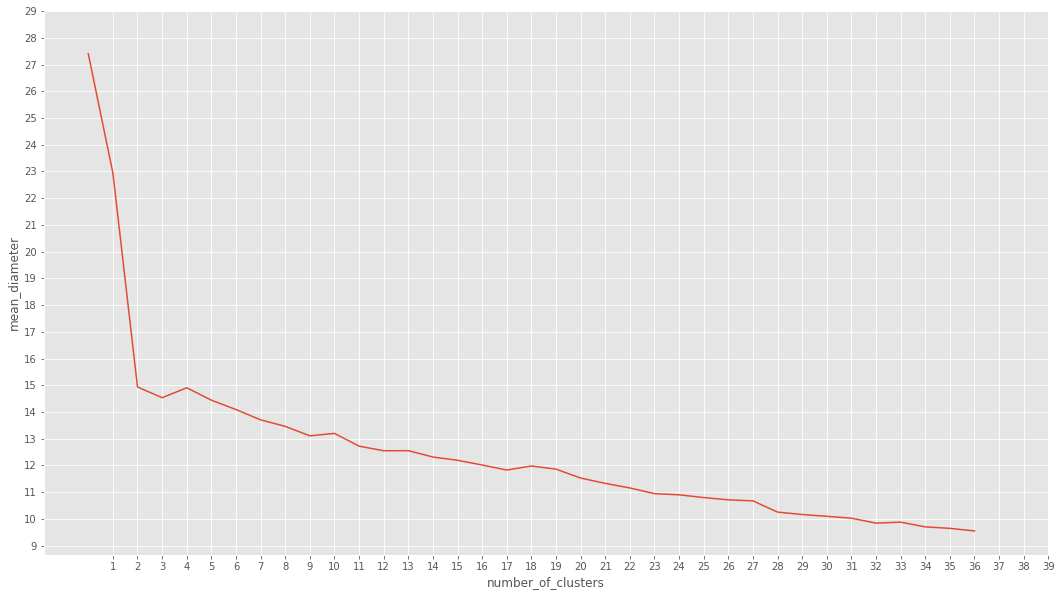

In [55]:
diams = []
for i in xrange(3, 40):
    model = AgglomerativeClustering(n_clusters=i)
    y = model.fit_predict(X)
    sum = 0
    clusts_not_null = 0
    for label in xrange(i):
        dists = pdist(X[np.where(model.labels_==label)])
        if len(dists) != 0: 
            sum += dists.max()
            clusts_not_null += 1
    diams.append(sum/float(clusts_not_null))
plt.plot(diams)
plt.xticks(np.arange(1, 40))
plt.yticks(np.arange(9, 30))
plt.xlabel("number_of_clusters")
plt.ylabel("mean_diameter")

### Linkage='complete'

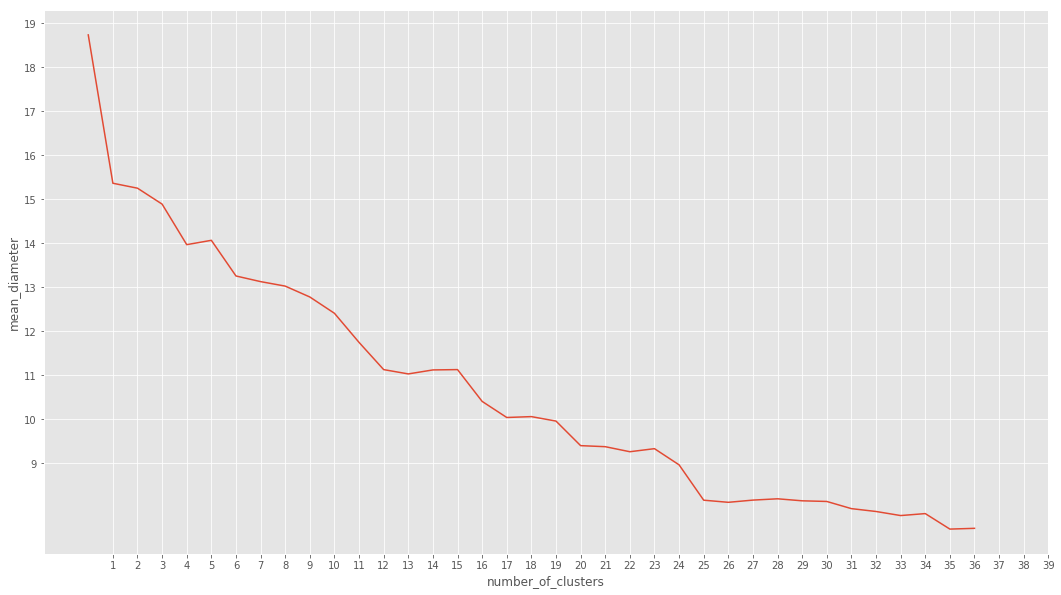

In [56]:
diams = []
for i in xrange(3, 40):
    model = AgglomerativeClustering(n_clusters=i, linkage='complete')
    y = model.fit_predict(X)
    sum = 0
    clusts_not_null = 0
    for label in xrange(i):
        dists = pdist(X[np.where(model.labels_==label)])
        if len(dists) != 0: 
            sum += dists.max()
            clusts_not_null += 1
    diams.append(sum/float(clusts_not_null))
plt.plot(diams)
plt.xticks(np.arange(1, 40))
plt.yticks(np.arange(9, 20))
plt.xlabel("number_of_clusters")
plt.ylabel("mean_diameter")

### Linkage='average'

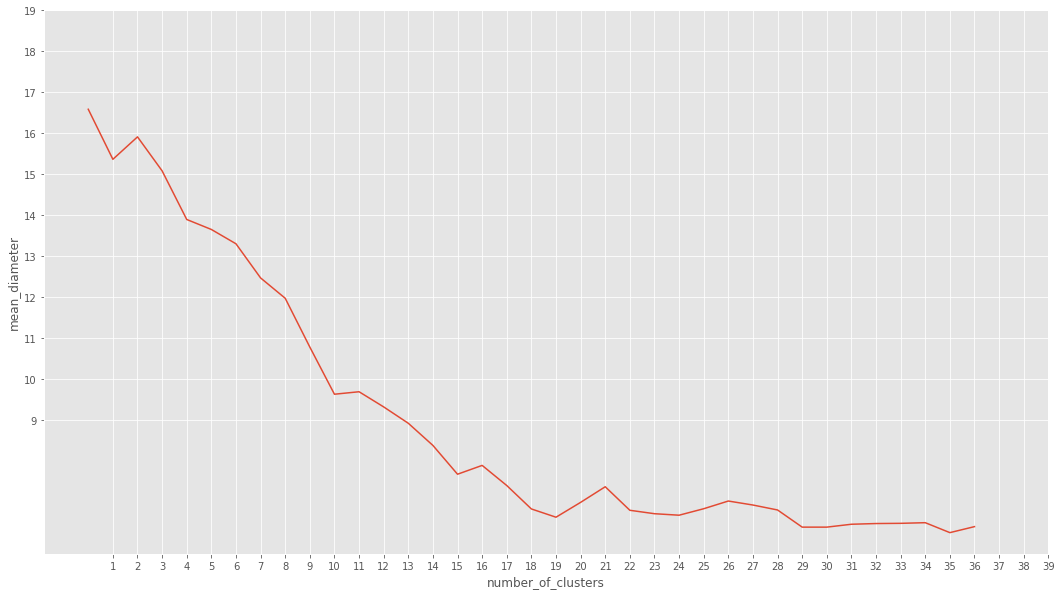

In [57]:
diams = []
for i in xrange(3, 40):
    model = AgglomerativeClustering(n_clusters=i, linkage='average')
    y = model.fit_predict(X)
    sum = 0
    clusts_not_null = 0
    for label in xrange(i):
        dists = pdist(X[np.where(model.labels_==label)])
        if len(dists) != 0: 
            sum += dists.max()
            clusts_not_null += 1
    diams.append(sum/float(clusts_not_null))
plt.plot(diams)
plt.xticks(np.arange(1, 40))
plt.yticks(np.arange(9, 20))
plt.xlabel("number_of_clusters")
plt.ylabel("mean_diameter")

## Итоговый выбор модели

При выборе параметров руководствуемся следующими соображениями:

1) Слишком малое количество кластеров(меньше 10) приведет к тому, что большая часть Москвы в пределах МКАД выделится в 2 или 3 кластера - неудовлетворительный результат.

2) Слишком большое число(больше 25) тяжело интерпретируемо, ведь нас на данном этапе интересует общая картина.

Предполагаемое число кластеров по лучшим результатам: 

KMeans:
    
    Средний диаметр - 12
    
Иерархическая кластеризация:

    Средний диаметр - 11
    
Возьмем - 12. Алгоритм - Иерархическая кластеризация, потому что показывает неплохое качество и считается точнее KMeans.

## Почему так плохо?

Территория Москвы некомпактна - отдельные районы с малым числом домов удалены от метро, центра, некоторых других объектов.

## Что хорошо?

???

## Как можно улучшить?

1) Другой набор фич

2) Внутри каждого полученного кластера провести новую кластеризацию

3) ...

## Визуализация

После отрисовки не забыть описать кластеры, причем можно вернуться к исходным значениям и назвать их средние значения по кластерам.

In [61]:
model = AgglomerativeClustering(n_clusters=12)
y = model.fit_predict(X)

In [62]:
mos_center = [55.750475, 37.619020]
moscow = folium.Map(location=mos_center, zoom_start=11, control_scale=True)

In [64]:
color_names = ['red', 'blue', 'green', 'yellow', 'orange', 'grey', 'black']
colors = map(lambda i: color_names[i], y)

In [35]:
for lt, ln, c in zip(lat[:2000], lon[:2000], colors):
    folium.CircleMarker(location=[lt, ln], radius=3, color=c).add_to(moscow)
moscow

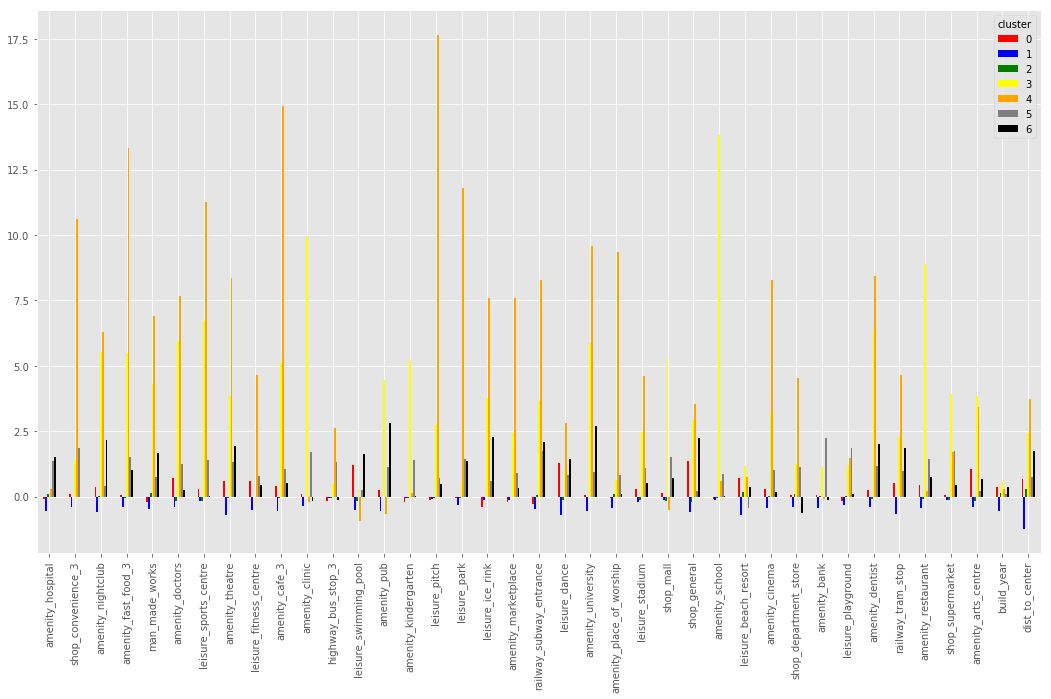

In [37]:
data_temp = pd.DataFrame(data=X, columns=df.columns)
data_temp['cluster'] = y
grouped = data_temp.groupby('cluster').mean()
grouped.transpose().plot.bar(use_index = True, color=color_names);

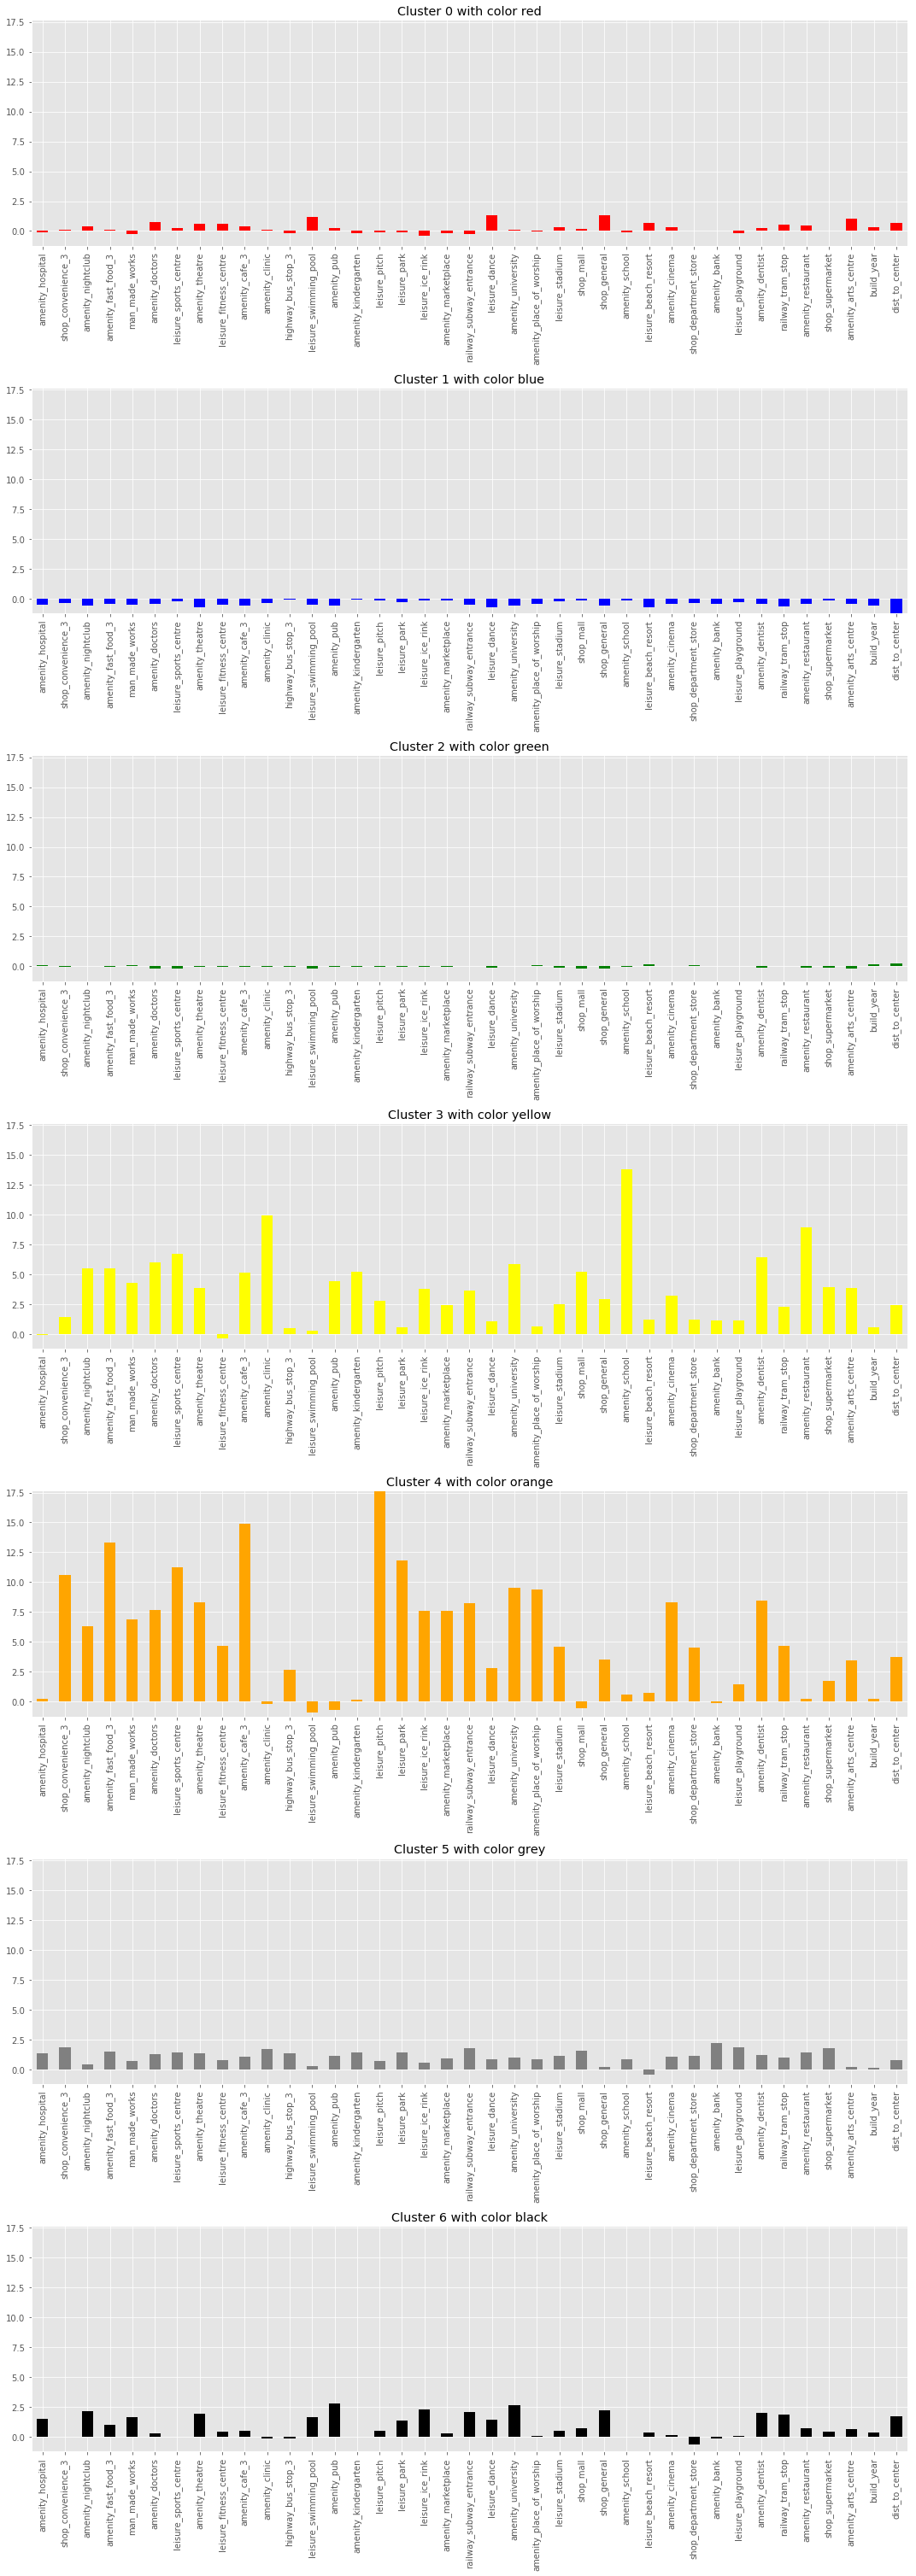

In [38]:
plt.figure(figsize=(15, grouped.shape[0] * 6))
ymax = grouped.values.max()
ymin = grouped.values.min()

for i in range(grouped.shape[0]):
    plt.subplot(grouped.shape[0], 1, i+1)
    grouped.iloc[i, :].plot.bar(color=color_names[i])
    plt.ylim((ymin, ymax))
    plt.title('Cluster %d with color %s' % (i, color_names[i]))
    
plt.tight_layout()